[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/weaviate/recipes/blob/main/integrations/llm-agent-frameworks/dspy/5.Advanced-Optimizers.ipynb)

## Welcome to the Notebook! 🥳

In this notebook, you will learn how to optimize your DSPy program using BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFewShotOptuna, COPRO, and MIPRO! 

We will use Cohere's `Command-R+` and `Command-R` LLMs, as well as OpenAI's `GPT-4`. We will log LLM calls and pipeline traces with `Arize Phoenix`, and show how you can use `Weights & Biases` to monitor `BootstrapFewShot` runs, our first step in this integration!

We will also of course use the `Weaviate` database, storing and indexing the Weaviate blog posts.


A few requirements:
1. You'll need a running Weaviate instance
    1. You can create a 14-day free cluster on [WCS](https://console.weaviate.cloud/)
    2. Or run Weaviate locally (use the `yaml` file in this folder with `docker-compose up -d`)
2. Generate Cohere and/or OpenAI API keys
3. Installations
    1. weaviate-client
    2. dspy-ai
4. Load your Weaviate cluster with data
    1. If you want to use the Weaviate blogs as the dataset, refer to the `Weaviate-Import.ipynb` file in this folder.

# Connect DSPy to our LLMs and Weaviate

In [20]:
import dspy
from dspy.retrieve.weaviate_rm import WeaviateRM
import weaviate

command_r = dspy.Cohere(model="command-r", max_tokens=4000, api_key=cohere_api_key)
command_r_plus = dspy.Cohere(model="command-r-plus", max_tokens=4000, api_key=cohere_api_key)
gpt4 = dspy.OpenAI(model="gpt-4", max_tokens=4000)

weaviate_client = weaviate.connect_to_local()
retriever_model = WeaviateRM("WeaviateBlogChunk", weaviate_client=weaviate_client)
dspy.settings.configure(lm=command_r, rm=retriever_model)

# Test Connection

In [21]:
print(command_r("say hello"))
print(gpt4("say hello"))

["Hello! How's it going?"]
['Hello! How can I assist you today?']


# Connect to Arize Phoenix Observability

In [24]:
# Phoenix Setup
import phoenix as px
phoenix_session = px.launch_app()

Existing running Phoenix instance detected! Shutting it down and starting a new instance...
🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [25]:
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


# Load Dataset

In [48]:
import json

file_path = './WeaviateBlogRAG-0-0-0.json'
with open(file_path, 'r') as file:
    dataset = json.load(file)

gold_answers = []
queries = []

for row in dataset:
    gold_answers.append(row["gold_answer"])
    queries.append(row["query"])
    
data = []

for i in range(len(gold_answers)):
    data.append(dspy.Example(gold_answer=gold_answers[i], question=queries[i]).with_inputs("question"))

trainset, devset, testset = data[:25], data[25:35], data[35:]

# Typed LLM Metrics

In [27]:
class TypedEvaluator(dspy.Signature):
    """Evaluate the quality of a system's answer to a question according to a given criterion."""
    
    criterion: str = dspy.InputField(desc="The evaluation criterion.")
    question: str = dspy.InputField(desc="The question asked to the system.")
    ground_truth_answer: str = dspy.InputField(desc="An expert written Ground Truth Answer to the question.")
    predicted_answer: str = dspy.InputField(desc="The system's answer to the question.")
    rating: float = dspy.OutputField(desc="A float rating between 1 and 5")


def MetricWrapper(gold, pred, trace=None):
    alignment_criterion = "How aligned is the predicted_answer with the ground_truth?"
    return dspy.TypedPredictor(TypedEvaluator)(criterion=alignment_criterion,
                                          question=gold.question,
                                          ground_truth_answer=gold.gold_answer,
                                          predicted_answer=pred.answer).rating

# RAG

In [28]:
class GenerateAnswer(dspy.Signature):
    """Assess the the context and answer the question."""

    context = dspy.InputField(desc="Helpful information for answering the question.")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="A detailed answer that is supported by the context.")
    
class RAG(dspy.Module):
    def __init__(self, k=3):
        super().__init__()
        
        self.retrieve = dspy.Retrieve(k=k)
        self.generate_answer = dspy.Predict(GenerateAnswer)
    
    def forward(self, question):
        context = self.retrieve(question).passages
        with dspy.context(lm=command_r):
            pred = self.generate_answer(context=context, question=question).answer
        return dspy.Prediction(context=context, answer=pred, question=question)

In [29]:
lgtm_query = "What do cross encoders do?"
toy_ground_truth_answer = """
Cross encoders score the relevance of a document to a query. They are commonly used to rerank documents.
"""
lgtm_example = dspy.Example(question=lgtm_query, gold_answer=toy_ground_truth_answer)

uncompiled_Prediction = RAG()(lgtm_query)
print(f"LGTM test query: {lgtm_query} \n \n ")
print(f"Uncompiled Answer: {uncompiled_Prediction.answer} \n \n")
test_example = dspy.Example(question=lgtm_query, gold_answer=toy_ground_truth_answer)
test_pred = uncompiled_Prediction
llm_metric_rating = MetricWrapper(test_example, test_pred)
print(f"LLM Metric Rating: {llm_metric_rating}")

LGTM test query: What do cross encoders do? 
 
 
Uncompiled Answer: Cross-encoders are ranking models used for content-based re-ranking. They employ a classification mechanism rather than producing vector embeddings. The input consists of a pair of data items, such as two sentences, and the output is a similarity score indicating how similar the pair is. Cross-encoders are known for achieving high in-domain accuracy, but they are time-consuming compared to bi-encoders. 
 

LLM Metric Rating: 4.0


In [32]:
command_r.inspect_history(n=2)




Evaluate the quality of a system's answer to a question according to a given criterion.

---

Follow the following format.

Criterion: The evaluation criterion.

Question: The question asked to the system.

Ground Truth Answer: An expert written Ground Truth Answer to the question.

Predicted Answer: The system's answer to the question.

Rating: A float rating between 1 and 5 (Respond with a single float value)

---

Criterion: How aligned is the predicted_answer with the ground_truth?

Question: What is the syntax error in the provided GraphQL query example related to the evaluation of n-gram matches?

Ground Truth Answer: The syntax error in the provided GraphQL query example is the missing comma between the `bm25` and `where` arguments in the `JobListing` function. This error could potentially affect the evaluation of n-gram matches by causing inaccurate keyword construction.

Predicted Answer: The context describes an evaluation method that looks for a match between keywords der

'\n\n\nEvaluate the quality of a system\'s answer to a question according to a given criterion.\n\n---\n\nFollow the following format.\n\nCriterion: The evaluation criterion.\n\nQuestion: The question asked to the system.\n\nGround Truth Answer: An expert written Ground Truth Answer to the question.\n\nPredicted Answer: The system\'s answer to the question.\n\nRating: A float rating between 1 and 5 (Respond with a single float value)\n\n---\n\nCriterion: How aligned is the predicted_answer with the ground_truth?\n\nQuestion: What is the syntax error in the provided GraphQL query example related to the evaluation of n-gram matches?\n\nGround Truth Answer: The syntax error in the provided GraphQL query example is the missing comma between the `bm25` and `where` arguments in the `JobListing` function. This error could potentially affect the evaluation of n-gram matches by causing inaccurate keyword construction.\n\nPredicted Answer: The context describes an evaluation method that looks fo

In [33]:
from dspy.evaluate.evaluate import Evaluate

evaluate = Evaluate(devset=devset, num_threads=4, display_progress=False)

uncompiled_score = evaluate(RAG(), metric=MetricWrapper)

Average Metric: 46.5 / 10  (465.0%)


# BootstrapFewShot

In [38]:
from dspy.teleprompt import BootstrapFewShot

# Replace with Teacher Model

teacher_settings = {"lm": command_r_plus}

for i in range(1, 4, 1):
    teleprompter = BootstrapFewShot(teacher_settings=teacher_settings,
                                    metric=MetricWrapper, 
                                    max_bootstrapped_demos=i, 
                                    max_rounds=1)
    compiled_RAG = teleprompter.compile(RAG(), trainset=trainset)
    compiled_RAG_score = evaluate(compiled_RAG, metric=MetricWrapper)
    print(f"\n\033[91mCompiled RAG Score at Demos = {i}: {compiled_RAG_score}\n")

  4%|█▋                                        | 1/25 [00:01<00:34,  1.43s/it]


Bootstrapped 1 full traces after 2 examples in round 0.
Average Metric: 47.5 / 10  (475.0%)

Compiled RAG Score at Demos = 1: 475.0



  8%|███▎                                      | 2/25 [00:02<00:31,  1.37s/it]


Bootstrapped 2 full traces after 3 examples in round 0.
Average Metric: 45.75 / 10  (457.5%)

Compiled RAG Score at Demos = 2: 457.5



 12%|█████                                     | 3/25 [00:03<00:27,  1.24s/it]


Bootstrapped 3 full traces after 4 examples in round 0.
Average Metric: 45.5 / 10  (455.0%)

Compiled RAG Score at Demos = 3: 455.0



# Weights & Biases

Learn more about how you can use Weights & Biases logging for `BootstrapFewShot` runs [here!](https://github.com/weaviate/recipes/blob/main/integrations/weights_and_biases/wandb_logging_RAG_dspy_cohere.ipynb)

In [PR #849] to DSPy, we introduce wandb logging in order to see the `metric_val` returned for each bootstrapped example. To motivate the use case, you may have a rating on a scale of 1 to 5 for answers and you only want to use examples that achieve a 5 in your prompt. This is the first of many in our collaborations between Weaviate and Weights & Biases!

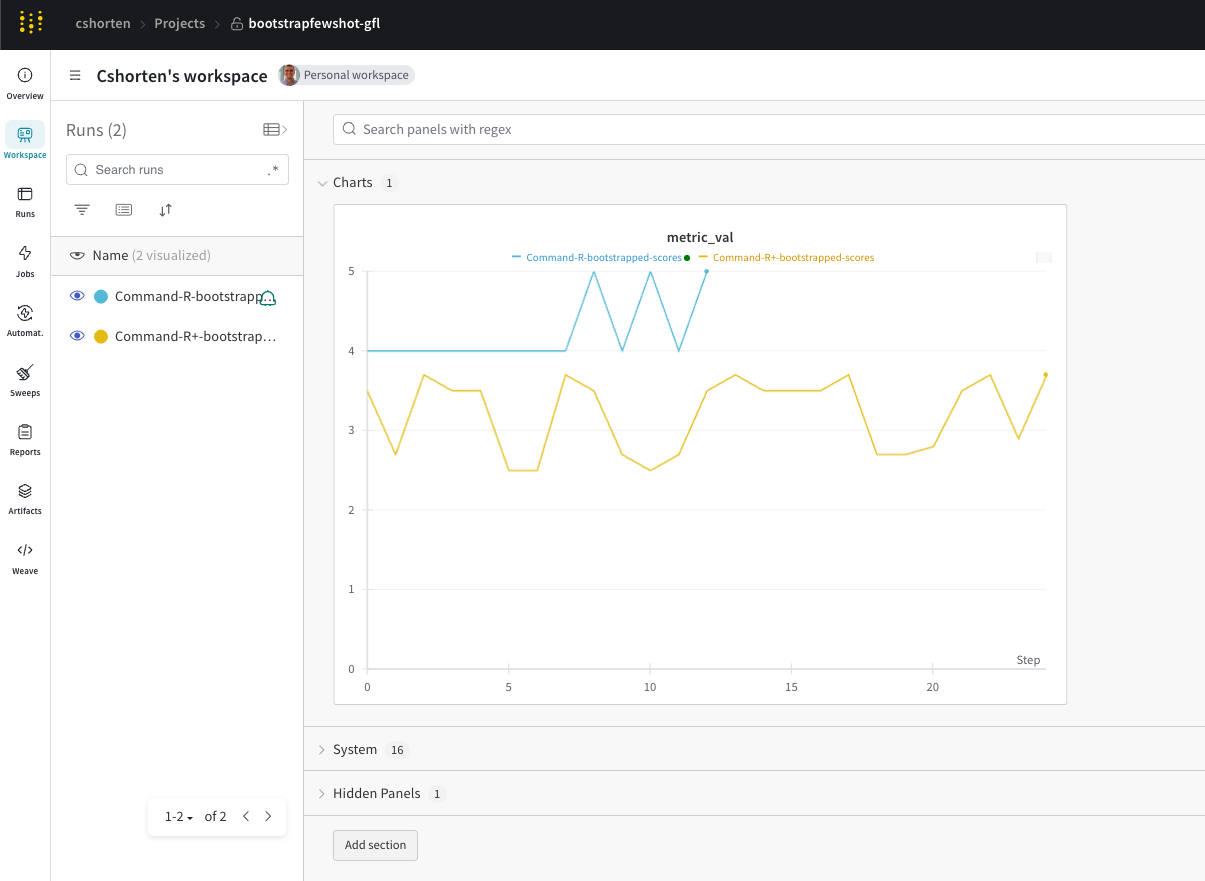

In [7]:
from IPython.display import Image, display

display(Image(filename='./weights_and_biases/RAG-optimization-dashboard.png'))

# BootstrapFewShotWithRandomSearch

In [39]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

teacher_settings = {"lm": command_r}

teleprompter = BootstrapFewShotWithRandomSearch(teacher_settings=teacher_settings,
                                                metric=MetricWrapper,
                                                max_bootstrapped_demos=2,
                                                num_candidate_programs=2)

compiled_RAG = teleprompter.compile(RAG(), trainset=trainset)
compiled_RAG_score = evaluate(compiled_RAG, metric=MetricWrapper)
print(f"\n\033[91mCompiled RAG Score: {compiled_RAG_score}\n")

Going to sample between 1 and 2 traces per predictor.
Will attempt to train 2 candidate sets.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.65it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [0]
New best score: 426.0 for seed -3
Scores so far: [426.0]
Best score: 426.0


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.64it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [16]
Scores so far: [426.0, 426.0]
Best score: 426.0


  8%|███▎                                      | 2/25 [00:02<00:27,  1.21s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 104.5 / 25  (418.0): 100%|████| 25/25 [00:07<00:00,  3.33it/s]


Average Metric: 104.5 / 25  (418.0%)
Score: 418.0 for set: [16]
Scores so far: [426.0, 426.0, 418.0]
Best score: 426.0
Average of max per entry across top 1 scores: 4.26
Average of max per entry across top 2 scores: 4.28
Average of max per entry across top 3 scores: 4.36
Average of max per entry across top 5 scores: 4.36
Average of max per entry across top 8 scores: 4.36
Average of max per entry across top 9999 scores: 4.36


  8%|███▎                                      | 2/25 [00:02<00:32,  1.42s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.71it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [16]
Scores so far: [426.0, 426.0, 418.0, 426.0]
Best score: 426.0
Average of max per entry across top 1 scores: 4.26
Average of max per entry across top 2 scores: 4.28
Average of max per entry across top 3 scores: 4.42
Average of max per entry across top 5 scores: 4.46
Average of max per entry across top 8 scores: 4.46
Average of max per entry across top 9999 scores: 4.46


  4%|█▋                                        | 1/25 [00:01<00:47,  1.98s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:08<00:00,  3.11it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [16]
Scores so far: [426.0, 426.0, 418.0, 426.0, 426.0]
Best score: 426.0
Average of max per entry across top 1 scores: 4.26
Average of max per entry across top 2 scores: 4.28
Average of max per entry across top 3 scores: 4.42
Average of max per entry across top 5 scores: 4.62
Average of max per entry across top 8 scores: 4.62
Average of max per entry across top 9999 scores: 4.62
5 candidate programs found.
Average Metric: 46.5 / 10  (465.0%)

Compiled RAG Score: 465.0



In [40]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

teacher_settings = {"lm": command_r}

teleprompter = BootstrapFewShotWithRandomSearch(teacher_settings=teacher_settings,
                                                metric=MetricWrapper,
                                                max_bootstrapped_demos=1,
                                                num_candidate_programs=5)

compiled_RAG = teleprompter.compile(RAG(), trainset=trainset)
compiled_RAG_score = evaluate(compiled_RAG, metric=MetricWrapper)
print(f"\n\033[91mCompiled RAG Score: {compiled_RAG_score}\n")

Going to sample between 1 and 1 traces per predictor.
Will attempt to train 5 candidate sets.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.54it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [0]
New best score: 426.0 for seed -3
Scores so far: [426.0]
Best score: 426.0


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.71it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [16]
Scores so far: [426.0, 426.0]
Best score: 426.0


  4%|█▋                                        | 1/25 [00:01<00:26,  1.12s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 107.5 / 25  (430.0): 100%|████| 25/25 [00:08<00:00,  2.87it/s]


Average Metric: 107.5 / 25  (430.0%)
Score: 430.0 for set: [16]
New best score: 430.0 for seed -1
Scores so far: [426.0, 426.0, 430.0]
Best score: 430.0
Average of max per entry across top 1 scores: 4.3
Average of max per entry across top 2 scores: 4.44
Average of max per entry across top 3 scores: 4.48
Average of max per entry across top 5 scores: 4.48
Average of max per entry across top 8 scores: 4.48
Average of max per entry across top 9999 scores: 4.48


  4%|█▋                                        | 1/25 [00:01<00:44,  1.87s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 107.36 / 25  (429.4): 100%|███| 25/25 [00:38<00:00,  1.52s/it]


Average Metric: 107.36 / 25  (429.4%)
Score: 429.44 for set: [16]
Scores so far: [426.0, 426.0, 430.0, 429.44]
Best score: 430.0
Average of max per entry across top 1 scores: 4.3
Average of max per entry across top 2 scores: 4.5344
Average of max per entry across top 3 scores: 4.6344
Average of max per entry across top 5 scores: 4.6744
Average of max per entry across top 8 scores: 4.6744
Average of max per entry across top 9999 scores: 4.6744


  4%|█▋                                        | 1/25 [00:02<00:52,  2.17s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 105.5 / 25  (422.0): 100%|████| 25/25 [00:07<00:00,  3.17it/s]


Average Metric: 105.5 / 25  (422.0%)
Score: 422.0 for set: [16]
Scores so far: [426.0, 426.0, 430.0, 429.44, 422.0]
Best score: 430.0
Average of max per entry across top 1 scores: 4.3
Average of max per entry across top 2 scores: 4.5344
Average of max per entry across top 3 scores: 4.6344
Average of max per entry across top 5 scores: 4.72
Average of max per entry across top 8 scores: 4.72
Average of max per entry across top 9999 scores: 4.72


  4%|█▋                                        | 1/25 [00:00<00:23,  1.01it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 106.0 / 25  (424.0): 100%|████| 25/25 [00:07<00:00,  3.32it/s]


Average Metric: 106.0 / 25  (424.0%)
Score: 424.0 for set: [16]
Scores so far: [426.0, 426.0, 430.0, 429.44, 422.0, 424.0]
Best score: 430.0
Average of max per entry across top 1 scores: 4.3
Average of max per entry across top 2 scores: 4.5344
Average of max per entry across top 3 scores: 4.6344
Average of max per entry across top 5 scores: 4.72
Average of max per entry across top 8 scores: 4.76
Average of max per entry across top 9999 scores: 4.76


  4%|█▋                                        | 1/25 [00:02<01:08,  2.84s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:10<00:00,  2.40it/s]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [16]
Scores so far: [426.0, 426.0, 430.0, 429.44, 422.0, 424.0, 426.0]
Best score: 430.0
Average of max per entry across top 1 scores: 4.3
Average of max per entry across top 2 scores: 4.5344
Average of max per entry across top 3 scores: 4.6344
Average of max per entry across top 5 scores: 4.7
Average of max per entry across top 8 scores: 4.78
Average of max per entry across top 9999 scores: 4.78


  4%|█▋                                        | 1/25 [00:01<00:45,  1.89s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:34<00:00,  1.37s/it]


Average Metric: 106.5 / 25  (426.0%)
Score: 426.0 for set: [16]
Scores so far: [426.0, 426.0, 430.0, 429.44, 422.0, 424.0, 426.0, 426.0]
Best score: 430.0
Average of max per entry across top 1 scores: 4.3
Average of max per entry across top 2 scores: 4.5344
Average of max per entry across top 3 scores: 4.6344
Average of max per entry across top 5 scores: 4.7
Average of max per entry across top 8 scores: 4.78
Average of max per entry across top 9999 scores: 4.78
8 candidate programs found.
Average Metric: 47.5 / 10  (475.0%)

Compiled RAG Score: 475.0



# BootstrapFewShotWithOptuna

In [41]:
from dspy.teleprompt import BootstrapFewShotWithOptuna

teacher_settings = {"lm": command_r}

teleprompter = BootstrapFewShotWithOptuna(teacher_settings=teacher_settings,
                                          metric=MetricWrapper,
                                          max_bootstrapped_demos=2,
                                          num_candidate_programs=2)

compiled_RAG = teleprompter.compile(RAG(), trainset=trainset, max_demos=2)
compiled_RAG_score = evaluate(compiled_RAG, metric=MetricWrapper)
print(f"\n\033[91mCompiled RAG Score: {compiled_RAG_score}\n")

Going to sample between 1 and 2 traces per predictor.
Will attempt to train 2 candidate sets.


  8%|███▎                                      | 2/25 [00:02<00:26,  1.17s/it]
[I 2024-04-14 19:53:22,635] A new study created in memory with name: no-name-2b4e80fd-1155-4f77-8f2c-bb040d481e89


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.71it/s]
[I 2024-04-14 19:53:31,878] Trial 0 finished with value: 426.0 and parameters: {'demo_index_for_generate_answer': 12}. Best is trial 0 with value: 426.0.


Average Metric: 106.5 / 25  (426.0%)


Average Metric: 106.5 / 25  (426.0): 100%|████| 25/25 [00:09<00:00,  2.78it/s]
[I 2024-04-14 19:53:40,901] Trial 1 finished with value: 426.0 and parameters: {'demo_index_for_generate_answer': 8}. Best is trial 0 with value: 426.0.


Average Metric: 106.5 / 25  (426.0%)
Best score: 426.0
Best program: generate_answer = Predict(GenerateAnswer(context, question -> answer
    instructions='Assess the the context and answer the question.'
    context = Field(annotation=str required=True json_schema_extra={'desc': 'Helpful information for answering the question.', '__dspy_field_type': 'input', 'prefix': 'Context:'})
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Question:', 'desc': '${question}'})
    answer = Field(annotation=str required=True json_schema_extra={'desc': 'A detailed answer that is supported by the context.', '__dspy_field_type': 'output', 'prefix': 'Answer:'})
))
Average Metric: 46.5 / 10  (465.0%)

Compiled RAG Score: 465.0



# COPRO

In [44]:
from dspy.teleprompt import COPRO

gpt4 = dspy.OpenAI(model="gpt-4-1106-preview", max_tokens=4000, model_type="chat")

COPRO_teleprompter = COPRO(prompt_model=gpt4,
                          metric=MetricWrapper,
                          breadth=5,
                          depth=3,
                          init_temperature=0.7,
                          verbose=False,
                          track_stats=True)
kwargs = dict(num_threads=1, display_progress=True, display_table=5)

COPRO_compiled_RAG = COPRO_teleprompter.compile(RAG(), trainset=trainset[:3], eval_kwargs=kwargs)
eval_score = evaluate(COPRO_compiled_RAG, metric=MetricWrapper)
print(eval_score)

Iteration Depth: 1/3.
At Depth 1/3, Evaluating Prompt Candidate #1/5 for Predictor 1 of 1.


Average Metric: 12.5 / 3  (416.7): 100%|████████| 3/3 [00:04<00:00,  1.54s/it]

Average Metric: 12.5 / 3  (416.7%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.5' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm because it allows the algorithm to weigh the uniqueness of each keyword in...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries are not suitable for real-time updates or scalable semantic search because the index data is immutable. This means that while incredibly fast, the...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by CommandBar import StayConnected from '/_includes/stay-connected.mdx' for learning about LangChain projects. The guide's link is provided as: https://www.commandbar.com/blog/langchain-projects.,What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 1/3, Evaluating Prompt Candidate #2/5 for Predictor 1 of 1.


Average Metric: 12.0 / 3  (400.0): 100%|████████| 3/3 [00:03<00:00,  1.14s/it]

Average Metric: 12.0 / 3  (400.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm used in Weaviate's hybrid search. It is a scoring method that calculates the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for real-time updates or scalable semantic search because the index data is immutable. This means vector libraries are ideal for...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by CommandBar - https://www.commandbar.com/blog/langchain-projects for learning about LangChain projects.,What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 1/3, Evaluating Prompt Candidate #3/5 for Predictor 1 of 1.


Average Metric: 12.0 / 3  (400.0): 100%|████████| 3/3 [00:03<00:00,  1.32s/it]

Average Metric: 12.0 / 3  (400.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm used in Weaviate's hybrid search. It is a scoring method that calculates the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for real-time updates and scalable semantic search because the index data is immutable. This means vector libraries are limited to...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by CommandBar import StayConnected from '/_includes/stay-connected.mdx' for learning about LangChain projects. The guide's link is provided as: https://www.commandbar.com/blog/langchain-projects.,What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 1/3, Evaluating Prompt Candidate #4/5 for Predictor 1 of 1.


Average Metric: 13.0 / 3  (433.3): 100%|████████| 3/3 [00:04<00:00,  1.36s/it]

Average Metric: 13.0 / 3  (433.3%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.5' '4.5' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm used in Weaviate's hybrid search. It forms the basis for the calculation of...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.5
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for real-time updates or scalable semantic searches because the index data is immutable. This means that while vector libraries are...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by CommandBar import StayConnected from '/_includes/stay-connected.mdx' for learning about LangChain projects. The guide's link is provided as https://www.commandbar.com/blog/langchain-projects.,What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 1/3, Evaluating Prompt Candidate #5/5 for Predictor 1 of 1.


Average Metric: 12.5 / 3  (416.7): 100%|████████| 3/3 [00:04<00:00,  1.50s/it]

Average Metric: 12.5 / 3  (416.7%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.5' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...","Context: The Binary Independence Model is incorporated into the BM25 algorithm used in Weaviate, a component of the Term-Frequency Inverse-Document Frequency (TF-IDF) scoring method. It's...",What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries are not suitable for applications requiring real-time updates and scalable semantic search because the index data is immutable, meaning no real-time updates are...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by Paul from CommandBar import StayConnected for learning about LangChain projects. The guide's link is provided as: https://www.commandbar.com/blog/langchain-projects.,What guide does the document recommend for learning about LangChain projects?,4.0


Iteration Depth: 2/3.
At Depth 2/3, Evaluating Prompt Candidate #1/5 for Predictor 1 of 1.


Average Metric: 12.0 / 3  (400.0): 100%|████████| 3/3 [00:04<00:00,  1.48s/it]

Average Metric: 12.0 / 3  (400.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm used in Weaviate's hybrid search. It is a scoring method that calculates the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries are not suitable for applications requiring real-time updates and scalable semantic search because they store data immutablely, preventing real-time updatability. This immutability means...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...","The document recommends the LangChain Guide by Paul from CommandBar, which can be found at the URL: https://www.commandbar.com/blog/langchain-projects. The information is provided in the section...",What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 2/3, Evaluating Prompt Candidate #2/5 for Predictor 1 of 1.


Average Metric: 12.75 / 3  (425.0): 100%|███████| 3/3 [00:05<00:00,  1.70s/it]

Average Metric: 12.75 / 3  (425.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.75' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm employed by Weaviate's hybrid search mechanism. It forms the basis for calculating the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.75
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for real-time updates or scalable semantic search because the index data is immutable. This immutability means that while being excellent...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide available at https://www.commandbar.com/blog/langchain-projects for learning about LangChain projects. The guide provides an in-depth introduction and resources related to LangChain.,What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 2/3, Evaluating Prompt Candidate #3/5 for Predictor 1 of 1.


Average Metric: 13.0 / 3  (433.3): 100%|████████| 3/3 [00:04<00:00,  1.51s/it]

Average Metric: 13.0 / 3  (433.3%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.5' '4.5' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a critical component of the BM25 algorithm employed in Weaviate's hybrid search. It serves as the foundation for calculating the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.5
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries are not suitable for real-time updates or scalable semantic search because they store data in immutable indexes, which makes real-time updates impossible. This...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...","The document recommends the LangChain Guide at https://www.commandbar.com/blog/langchain-projects for learning about LangChain projects. The guide is mentioned in the Context section, with a direct link...",What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 2/3, Evaluating Prompt Candidate #4/5 for Predictor 1 of 1.


Average Metric: 12.0 / 3  (400.0): 100%|████████| 3/3 [00:06<00:00,  2.31s/it]

Average Metric: 12.0 / 3  (400.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a critical component of the BM25 algorithm because it allows the algorithm to normalize or calibrate the length of a...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries are not suitable for applications requiring real-time updates and scalable semantic search because the index data is immutable, which means it's not possible...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...","The document recommends the LangChain Guide by Paul from CommandBar, available at https://www.commandbar.com/blog/langchain-projects. It is specifically designed to help readers learn about LangChain and its...",What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 2/3, Evaluating Prompt Candidate #5/5 for Predictor 1 of 1.


Average Metric: 12.0 / 3  (400.0): 100%|████████| 3/3 [00:04<00:00,  1.56s/it]

Average Metric: 12.0 / 3  (400.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm used in Weaviate's hybrid search. It enables the algorithm to calculate the score...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for real-time updates or scalable semantic search because the index data is immutable. This immutability means vector libraries are best...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by CommandBar import StayConnected from '/_includes/stay-connected.mdx' for learning about LangChain projects. The guide's link is provided as https://www.commandbar.com/blog/langchain-projects. It...,What guide does the document recommend for learning about LangChain projects?,4.0


Iteration Depth: 3/3.
At Depth 3/3, Evaluating Prompt Candidate #1/5 for Predictor 1 of 1.


Average Metric: 12.75 / 3  (425.0): 100%|███████| 3/3 [00:09<00:00,  3.05s/it]

Average Metric: 12.75 / 3  (425.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.75' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a critical component of the BM25 algorithm employed by Weaviate's hybrid search mechanism. It forms the foundation for calculating the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.75
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries, though efficient for vector searches, have a key limitation regarding their immutability, which makes real-time updates impossible. This characteristic makes them less suitable...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...","Context: The provided document contains resources for getting started with contributing to open-source software and introductions to Weaviate and LangChain, seemingly related to a project...",What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 3/3, Evaluating Prompt Candidate #2/5 for Predictor 1 of 1.


Average Metric: 14.5 / 3  (483.3): 100%|████████| 3/3 [00:04<00:00,  1.46s/it]

Average Metric: 14.5 / 3  (483.3%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['5.0' '4.5' '5.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...","The Binary Independence Model is a key component of the BM25 algorithm because it helps determine the score of a document, query pair. By incorporating...",What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,5.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for applications requiring real-time updates and scalable semantic search because the index data is immutable. This means that while vector...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the *LangChain Guide* by Paul from CommandBar for learning about LangChain projects. The guide can be accessed at the URL: https://www.commandbar.com/blog/langchain-projects.,What guide does the document recommend for learning about LangChain projects?,5.0


At Depth 3/3, Evaluating Prompt Candidate #3/5 for Predictor 1 of 1.


Average Metric: 13.0 / 3  (433.3): 100%|████████| 3/3 [00:03<00:00,  1.19s/it]

Average Metric: 13.0 / 3  (433.3%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.5' '4.5' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a component of the BM25 algorithm employed in Weaviate's hybrid search. It contributes to the calculation of the Term-Frequency Inverse-Document...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.5
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are not suitable for real-time updates or scalable semantic search because the index data is immutable. This immutability means that while vector libraries...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...","The document recommends the LangChain Guide by Paul from CommandBar, titled *LangChain Projects*. The guide can be accessed at the URL: https://www.commandbar.com/blog/langchain-projects.",What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 3/3, Evaluating Prompt Candidate #4/5 for Predictor 1 of 1.


Average Metric: 12.5 / 3  (416.7): 100%|████████| 3/3 [00:03<00:00,  1.20s/it]

Average Metric: 12.5 / 3  (416.7%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.5' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a key component of the BM25 algorithm as it forms the basis for the calculation of the document score in...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...",Vector libraries are inefficient for applications requiring real-time updates and scalable semantic search due to their limitation of having immutable index data. This prevents real-time...,Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.5
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",The document recommends the LangChain Guide by CommandBar import StayConnected from '/_includes/stay-connected.mdx' for learning about LangChain projects. The guide's link is provided as: https://www.commandbar.com/blog/langchain-projects.,What guide does the document recommend for learning about LangChain projects?,4.0


At Depth 3/3, Evaluating Prompt Candidate #5/5 for Predictor 1 of 1.


Average Metric: 12.0 / 3  (400.0): 100%|████████| 3/3 [00:05<00:00,  1.90s/it]

Average Metric: 12.0 / 3  (400.0%)



/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/dspy_ai-2.4.1-py3.10.egg/dspy/evaluate/evaluate.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4.0' '4.0' '4.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, metric_name] = df[metric_name].apply(


,gold_answer,example_question,context,answer,pred_question,MetricWrapper
0,The Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search plays a crucial role in the calculation of the Inverse Document Frequency...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,"['Note, the current implementation of hybrid search in Weaviate uses BM25/BM25F and vector search. If you’re interested to learn about how dense vector indexes are...",The Binary Independence Model is a crucial component of the BM25 algorithm employed by Weaviate's hybrid search mechanism. It forms the foundation for calculating the...,What is the role of the Binary Independence Model in the BM25 algorithm used by Weaviate's hybrid search?,4.0
1,"Vector libraries might not be suitable for applications that require real-time updates and scalable semantic search because they have immutable index data, preventing real-time updates....",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,"['Updatability: The index data is immutable, and thus no real-time updates are possible. 2. Scalability: Most vector libraries cannot be queried while importing your data,...","Vector libraries are not suitable for real-time updates or scalable semantic search because they store vector embeddings in immutable, in-memory indexes. This immutability means that...",Why might vector libraries not be suitable for applications that require real-time updates and scalable semantic search?,4.0
2,"The document recommends the ""LangChain Guide"" by Paul from CommandBar for learning about LangChain projects.",What guide does the document recommend for learning about LangChain projects?,"[""I recommend checking out the GitHub repository to test this out yourself!\n\n## Additional Resources\n• [LangChain Guide](https://www.commandbar.com/blog/langchain-projects) by Paul from CommandBar. import StayConnected from '/_includes/stay-connected.mdx'\n\n"",...",Context: The provided document contains various resources and guides related to Weaviate and open-source contribution. Question: What guide does the document recommend for learning about...,What guide does the document recommend for learning about LangChain projects?,4.0


Average Metric: 44.5 / 10  (445.0%)
445.0


In [45]:
print(COPRO_compiled_RAG(question="What is ref2vec?").answer)

Ref2Vec, short for reference-to-vector, is a Weaviate 1.16 module that enables vectorization of data objects while incorporating cross-references to other objects. Essentially, it generates a vector representation of the referencing object by computing the average, or centroid vector, of its cross-referenced vectors. This approach holds value for use cases like recommendations, re-ranking, and representing lengthy objects. 

Ref2Vec offers an efficient and powerful way to implement recommendation systems. It allows for real-time updates of user vectors, factoring in user preferences and actions. The process is computationally lightweight, ensuring swift and relevant results. In essence, it transforms Weaviate into a tool for recommendations with "user-as-query," enabling swift development of features akin to a Home Feed.


In [47]:
print(command_r.inspect_history(n=1))




Proposed Instruction: Delve into the provided material, meticulously parsing through each detail and subtlety to gain a comprehensive understanding of the subject matter. Once you have thoroughly analyzed the context, proceed to answer the question with precision and coherence. Your response should succinctly encapsulate the relevant points and be directly responsive to the question's core. For queries that are inherently subjective or require extrapolation beyond the given information, articulate a reasoned argument, underpinned by evidence from the material and sound logic. In instances where the information at hand is incomplete or ambiguous, transparently communicate the limitations, while providing an educated estimation or hypothesis, noting any premises upon which your inference is based. Your goal is to furnish an enlightening and instructive answer that not only addresses the query but also advances the overall understanding of the topic at hand.

---

Follow the following 

# Typed COPRO

[Work in Progress]

```python
from dspy.evaluate.evaluate import Evaluate

evaluator_for_TypedCOPRO = Evaluate(metric=MetricWrapper, devset=devset, num_threads=4, display_progress=False)

from dspy.teleprompt import optimize_signature

TypedCOPRO_compiled_RAG = optimize_signature(
    student=RAG(),
    evaluator=evaluator_for_TypedCOPRO,
    n_iterations=10,
    sorted_order="increasing",
    strategy="best",
    max_examples=20,
    prompt_model=command_r,
    initial_prompts=2,
    verbose=False,
)

eval_score = evaluate(TypedCOPRO_compiled_RAG, metric=MetricWrapper)
print(eval_score)
```

# MIPRO

In [22]:
class ObservationSummarizer(dspy.Signature):
    """Given a series of observations I have made about my dataset, please summarize them into a brief 2-3 sentence summary which highlights only the most important details."""

    observations = dspy.InputField(desc="Observations I have made about my dataset")
    summary = dspy.OutputField(
        desc="Two to Three sentence summary of only the most significant highlights of my observations",
    )


class DatasetDescriptor(dspy.Signature):
    (
        """Given several examples from a dataset please write observations about trends that hold for most or all of the samples. """
        """Some areas you may consider in your observations: topics, content, syntax, conciceness, etc. """
        """It will be useful to make an educated guess as to the nature of the task this dataset will enable. Don't be afraid to be creative"""
    )

    examples = dspy.InputField(desc="Sample data points from the dataset")
    observations = dspy.OutputField(desc="Somethings that holds true for most or all of the data you observed")


class DatasetDescriptorWithPriorObservations(dspy.Signature):
    (
        """Given several examples from a dataset please write observations about trends that hold for most or all of the samples. """
        """I will also provide you with a few observations I have already made.  Please add your own observations or if you feel the observations are comprehensive say 'COMPLETE' """
        """Some areas you may consider in your observations: topics, content, syntax, conciceness, etc. """
        """It will be useful to make an educated guess as to the nature of the task this dataset will enable. Don't be afraid to be creative"""
    )

    examples = dspy.InputField(desc="Sample data points from the dataset")
    prior_observations = dspy.InputField(desc="Some prior observations I made about the data")
    observations = dspy.OutputField(
        desc="Somethings that holds true for most or all of the data you observed or COMPLETE if you have nothing to add",
    )

In [26]:
dspy.settings.configure(lm=gpt4)

dataset_descriptor = dspy.Predict(DatasetDescriptor)
dataset_descriptor_with_prior = dspy.Predict(DatasetDescriptorWithPriorObservations)
observation_summarizer = dspy.Predict(ObservationSummarizer)

def examples_to_strings(trainset):
    example_strings = []
    for example in trainset:
        question = example.question
        gold_answer = example.gold_answer
        example_string = f"Question: {question}\nAnswer: {gold_answer}"
        example_strings.append(example_string)
    return example_strings

batch_size=5
dataset_description = ""
for start_index in range(0, len(trainset), batch_size):
    examples = examples_to_strings(trainset[start_index:start_index+batch_size])
    examples = "".join(examples)
    if start_index == 0:
        dataset_description = dataset_descriptor(examples=examples).observations
    else:
        dataset_description = dataset_descriptor_with_prior(examples=examples,
                                                           prior_observations=dataset_description).observations
    summary = observation_summarizer(observations=dataset_description).summary
    print(f"\033[32m\nStart index: {start_index}.")
    print(f"\033[0m\nDatasetDescriptor output: {dataset_description}")
    print(f"\033[31m\nSummarizer output: {summary}\n")
    dataset_description = summary
    


Start index: 0.

DatasetDescriptor output: Observations:

1. The dataset contains a question-and-answer format, where each sample includes a specific question followed by a detailed answer that provides information or explains a concept related to technology, algorithms, or datasets.
2. The content is technical and seems to be focused on topics related to computer science, search algorithms, data compression, and machine learning libraries or tools.
3. The syntax is formal and precise, with a focus on clarity and accuracy. The language used is indicative of a knowledgeable source, possibly aimed at an audience familiar with the subject matter.
4. The answers are concise yet informative, aiming to provide a comprehensive explanation without unnecessary elaboration. They are structured to directly address the question posed.
5. There is a consistent use of technical terms and jargon, such as "Binary Independence Model," "Inverse Document Frequency," "CRUD support," and "semantic search,

In [27]:
from dspy.teleprompt import MIPRO

dspy.settings.configure(lm=command_r)

teleprompter = MIPRO(prompt_model=gpt4, task_model=command_r, metric=MetricWrapper, num_candidates=10, init_temperature=0.5)
kwargs = dict(num_threads=1, display_progress=True, display_table=0)
MIPRO_compiled_RAG = teleprompter.compile(RAG(), trainset=trainset, num_trials=3, max_bootstrapped_demos=1, max_labeled_demos=0, eval_kwargs=kwargs)
eval_score = evaluate(MIPRO_compiled_RAG, metric=MetricWrapper)
print(eval_score)


Please be advised that based on the parameters you have set, the maximum number of LM calls is projected as follows:

- Task Model: 25 examples in dev set * 3 trials * # of LM calls in your program = (75 * # of LM calls in your program) task model calls
- Prompt Model: # data summarizer calls (max 10) + 10 * 1 lm calls in program = 20 prompt model calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token) 
            + (Number of calls to prompt model * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).

For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may consider:

- Red


  4%|█▊                                          | 1/25 [00:02<00:52,  2.18s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:01<00:24,  1.01s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:02<00:53,  2.23s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:02<01:08,  2.85s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:00<00:22,  1.07it/s]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:01<00:41,  1.73s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:01<00:46,  1.95s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:01<00:34,  1.44s/it]


Bootstrapped 1 full traces after 2 examples in round 0.



  4%|█▊                                          | 1/25 [00:01<00:31,  1.30s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


[I 2024-04-01 23:09:02,814] A new study created in memory with name: no-name-0544ab56-44df-45a8-85a0-896ca66f8887


Starting trial #0



Average Metric: 78.5 / 25  (314.0): 100%|███████| 25/25 [01:28<00:00,  3.55s/it]
[I 2024-04-01 23:10:31,498] Trial 0 finished with value: 314.0 and parameters: {'11300723232_predictor_instruction': 1, '11300723232_predictor_demos': 1}. Best is trial 0 with value: 314.0.


Average Metric: 78.5 / 25  (314.0%)
Starting trial #1



Average Metric: 108.0 / 25  (432.0): 100%|██████| 25/25 [01:18<00:00,  3.15s/it]
[I 2024-04-01 23:11:50,187] Trial 1 finished with value: 432.0 and parameters: {'11300723232_predictor_instruction': 5, '11300723232_predictor_demos': 4}. Best is trial 1 with value: 432.0.


Average Metric: 108.0 / 25  (432.0%)
Starting trial #2



Average Metric: 104.5 / 25  (418.0): 100%|██████| 25/25 [01:04<00:00,  2.58s/it]
[I 2024-04-01 23:12:54,594] Trial 2 finished with value: 418.0 and parameters: {'11300723232_predictor_instruction': 3, '11300723232_predictor_demos': 0}. Best is trial 1 with value: 432.0.


Average Metric: 104.5 / 25  (418.0%)
Returning generate_answer = Predict(StringSignature(context, question -> answer
    instructions='Proposed Instruction: \nCarefully read the provided context, which may contain technical information, links, and code snippets related to advanced technology and machine learning topics. Your task is to interpret this information and provide a clear, concise, and accurate answer to the question posed. Use domain-specific language appropriate for an audience knowledgeable in computational linguistics or AI technologies. Ensure that your answer is context-rich and directly addresses the question, citing any specific resources or guides mentioned in the context when relevant.'
    context = Field(annotation=str required=True json_schema_extra={'desc': 'Helpful information for answering the question.', '__dspy_field_type': 'input', 'prefix': 'Context:'})
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'pref

In [28]:
print(MIPRO_compiled_RAG(question="What is ref2vec?").answer)

Ref2Vec, short for reference-to-vector, is a Weaviate module that enables vectorization of a data object by incorporating cross-references to other objects. It utilizes the centroid vector, also known as the average of cross-referenced vectors, to represent the referencing object. Ref2Vec is valuable for recommendation systems, re-ranking, and representing long objects. It allows for efficient real-time updates, making it suitable for building Home Feed features. The module's latest iteration is called ref2vec-centroid, and Weaviate's blog has more details on its development directions.


In [29]:
print(command_r.inspect_history(n=1))




Proposed Instruction: 
Carefully read the provided context, which may contain technical information, links, and code snippets related to advanced technology and machine learning topics. Your task is to interpret this information and provide a clear, concise, and accurate answer to the question posed. Use domain-specific language appropriate for an audience knowledgeable in computational linguistics or AI technologies. Ensure that your answer is context-rich and directly addresses the question, citing any specific resources or guides mentioned in the context when relevant.

---

Follow the following format.

Context: Helpful information for answering the question.
Question: ${question}
Answer: A detailed answer that is supported by the context.

---

Context:
[1] «For more information about this new feature, read this [blog post](/blog/ref2vec-centroid) by Connor Shorten. Weaviate also has a bunch of example use cases on [GitHub](https://github.com/weaviate/weaviate-examples). Find y